# Utilizando Machine Learning para prever os jogos do Campeonato Brasileiro de futebol

O intuito deste projeto é desenvolver um modelo preditivo capaz de prever o resultado das partidas do campeonato brasileiro de futebol. 
O modelo tem como saída os seguintes resultados:
* 1: Vitória da equipe mandante;
* 0: Empate;
* -1: Vitória da equipe visitante

O dataset foi obtido do site Football-Data. O Football-Data é um portal de apostas de futebol gratuito que fornece resultados históricos e probabilidades para ajudar os entusiastas de apostas de futebol a analisar muitos anos de dados de forma rápida e eficiente.
> Link disponível em: https://www.football-data.co.uk/brazil.php

A organização deste notebook está dividida em:
* 1) Análise exploratória dos dados;
* 2) Limpeza e pré-processamento dos dados;
* 3) Modelagem;
* 4) Aplicação dos algoritmos de Machine Learning;
* 5) Utilizando o modelo para prever resultados do campeonato
* 6) Considerações finais
<br/><br/>

**Considerações sobre os resultados obtidos:**
<br/>
O modelo final obteve uma acurácia de 52.11%. O resultado pode ser considerado razoável, dado a dificuldade que é realizar esse tipo de previsão. Pontos positivos e negativos do modelo:
<br/>
Como positivo podemos considerar:
* O modelo consegue dizer de maneira geral quais são os 'níveis' das equipes. Por exemplo: Ele consegue dizer que Flamego RJ, Atlético MG e Palmeiras são as melhores equipes, tanto em 2020 quanto em 2021. E quando olhamos para o passado, em 2013 o Cruzeiro e Corinthians estavam entre os melhores. O que se confirma se olharmos a tabela daquele ano.
* Além disso podemos notar que o modelo consegue dizer com precisão quaise são os clubes que lutam para não cair. Exemplo de 2020 e 2021, onde o modelo acertou 5 dos 8 clubes que foram rebaixados nestes dois anos, e quase acertou mais dois. Botafogo RJ em 2020 e Juventude em 2021.
* O modelo foi bom em dizer quais foram as equipes que figuraram entre os 10 melhores do Brasil, acertando em 7 dos 10 casos.
<br/><br/>

Como avaliação negativa do modelo podemos considerar:
* O modelo não foi bom em dizer exatamente qual a posição que a equipe terminou o campeonato.
* O modelo também previu poucos empates, o que foi bastante negativo, dado que as equipes de meio de tabela empatam bastante seus jogos.

**Vamos começar importando as bibliotecas e carregando os dados**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import warnings
from matplotlib import style

Esta célula são configurações sobre os estilos que serão utilizados neste projeto.

In [14]:
sns.set_theme()
# Criação de um array contendo cores no formato hexadecimal
colors = ['#fffb2d', '#23ad2a','#ebebeb', '#36469c']
# Setando o palette de cores personalizadas
customPalette = sns.set_palette(sns.color_palette(colors))
#Mapeamento de estilos que serão utilizados para esse projeto
style.use('estilos/style_brasil.mplstyle')
plt.rcParams["figure.figsize"] = (14,8)


In [3]:
data = pd.read_csv('data/BRA.csv')

### 1) Análise exploratória dos dados

A primeira análise a ser feita é uma análise mais com teor de ver informações gerais mais superficiais sobre os dados. Informações sobre os tipos de dados, sobre as colunas, a quantidade de registros, distribuição dos dados, dentre outras informações.

In [4]:
data.dtypes

Country     object
League      object
Season       int64
Date        object
Time        object
Home        object
Away        object
HG         float64
AG         float64
Res         object
PH         float64
PD         float64
PA         float64
MaxH       float64
MaxD       float64
MaxA       float64
AvgH       float64
AvgD       float64
AvgA       float64
dtype: object

In [5]:
data.head()

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,Figueirense,Nautico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [6]:
data.shape

(3849, 19)

In [7]:
data.columns

Index(['Country', 'League', 'Season', 'Date', 'Time', 'Home', 'Away', 'HG',
       'AG', 'Res', 'PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD',
       'AvgA'],
      dtype='object')

De início vemos que o dataset possui algumas informações irrelevantes e outras que devem ser retiradas. O dataset possui 19 colunas, sendo RES o atributo target.
* Country: País (Irrelevante, pois todos os jogos ocorrem no mesmo país)
* League: Campeonato (Irrelevante, pois todos os jogos são do mesmo campeonato)
* Season: Temporada que ocorreu a partida.
* Date: Data que ocorreu a partida
* Time: Horário do jogo
* Home: Clube mandante
* Away: Clube visitante
* HG: Home Gols - Gols do clube mandante durante o tempo regulamentado. (Deve ser retirada, pois não é uma informação que se tem de antemão, e sim somente depois que o jogo acontece).
* AG: Away Gols - Gols do clube visitante durante o tempo regulamentado. (Deve ser retirada, pois não é uma informação que se tem de antemão, e sim somente depois que o jogo acontece).

Informações sobre os sites de apostas:
* PH: Probabilidade de vitória do clube mandante segundo a Pinnacle.
* PD: Probabilidade de empate segundo a Pinnacle.
* PA: Probabilidade de vitória do clube visitante segundo a Pinnacle.
* MaxH: Probabilidades máxima de vitória do clube mandante segundo o mercado.
* MaxD: Probabilidades máxima de empata segundo o mercado.
* MaxA: Probabilidades máxima de vitória do clube vistante segundo o mercado.
* AvgH: Probabilidades média de vitória do clube mandante segundo o mercado.
* AvgD: Probabilidades média de empate segundo o mercado.
* AvgA: Probabilidades média de vitória do clube visitante segundo o mercado.

* RES: Resultado (H - vitória do clube mandante; D - Empate; A - Vitória do clube visitante).

In [8]:
data.isnull().sum() #O dataset possui alguns valores missing que devemos tratar.

Country    0
League     0
Season     0
Date       0
Time       0
Home       0
Away       0
HG         1
AG         1
Res        1
PH         1
PD         1
PA         1
MaxH       0
MaxD       0
MaxA       0
AvgH       0
AvgD       0
AvgA       0
dtype: int64

In [9]:
data[data.duplicated()] #Não há dados duplicados

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA


In [10]:
data.describe()

,Season,HG,AG,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
count,3849.000000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000
mean,2016.570018,1.414501,0.943867,2.300218,3.657747,4.708545,2.380688,3.760483,4.969028,2.222055,3.484100,4.334679
std,2.920169,1.157684,0.973776,0.957730,0.651623,2.504508,1.076403,0.678611,2.800519,0.893556,0.562054,2.137199
min,2012.000000,0.000000,0.000000,1.080000,2.540000,1.150000,1.090000,2.630000,0.000000,1.070000,2.510000,1.150000
25%,2014.000000,1.000000,0.000000,1.690000,3.260000,2.990000,1.740000,3.350000,3.070000,1.650000,3.150000,2.860000
50%,2017.000000,1.000000,1.000000,2.080000,3.460000,4.020000,2.150000,3.540000,4.160000,2.030000,3.300000,3.740000
75%,2019.000000,2.000000,1.000000,2.600000,3.860000,5.760000,2.700000,3.970000,6.090000,2.510000,3.660000,5.310000
max,2022.000000,6.000000,6.000000,17.680000,12.250000,29.580000,29.000000,12.500000,36.000000,20.230000,10.820000,26.580000


Com essa descrição dos dados podemos perceber algumas coisas:
* A média de gols da equipe mandante é bem maior do que a média de gols da equipe visitante. Isso significa que muito provavelmente o fator jogar em casa é determinante para a vitória da equipe;
* De maneira geral os atributos relacionados a probabilidades (PH, PD, PA, MaxH, MaxD, MaxA, AvgH, AvgD, AvgA) estão bem distribuídos, pois as médias se aproximam bastante das suas respectivas medianas.
* A diferença entre valores mínimos e valores máximos é bastante alta, indício de que teremos aplicar a normalização destes dados.

In [11]:
#Biblioteca muito interessante para visualizar informações geradas automaticamente.
warnings.filterwarnings('ignore')
my_report = sv.analyze(data)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Proporção de vitórias, empates e derrotas em casa**<br/>
Ao analisar as vitórias, é possível observar que em quase metade das partidas o clube mandante se saiu vencedor, sendo o fator jogar em casa muito importante no contexto dos dados. 

In [12]:
res = pd.DataFrame(round(data['Res'].value_counts() / data['Res'].count() * 100, 2))
res.rename(columns={'Res': 'Porcentagem'}, inplace = True)
res.reset_index(inplace=True)
res

,index,Porcentagem
0,H,48.99
1,D,26.95
2,A,24.06


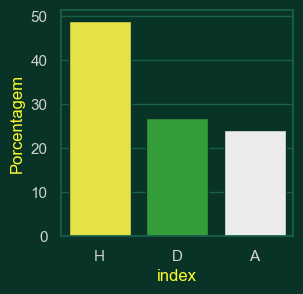

In [15]:
plt.figure(figsize=(3,3))
ax = sns.barplot(x="index", y="Porcentagem", data=res)

**Quais clubes mais jogaram?**

In [16]:
home = data['Home'].value_counts().to_frame()
away = data['Away'].value_counts().to_frame()

In [17]:
home['Away_qtd'] = away
total = home

In [18]:
total.reset_index(inplace=True)
total.rename(columns={'index': 'Team', 'home_team': 'home_qtd'}, inplace = True)

In [19]:
total['Away_qtd'].fillna(0, inplace=True)

In [20]:
# Estes são os clubes que mais jogaram jogos como mandantes.
total.head(10)

,Team,Home,Away_qtd
0,Flamengo RJ,193,192
1,Santos,193,192
2,Atletico-MG,193,192
3,Fluminense,192,193
4,Sao Paulo,192,193
5,Corinthians,192,193
6,Gremio,190,190
7,Palmeiras,174,173
8,Internacional,173,174
9,Botafogo RJ,154,155


In [21]:
#Estes são os clubes que mais jogaram jogos como visitantes na história
total.sort_values(by='Away_qtd', ascending=False).head(10)

,Team,Home,Away_qtd
4,Sao Paulo,192,193
5,Corinthians,192,193
3,Fluminense,192,193
0,Flamengo RJ,193,192
1,Santos,193,192
2,Atletico-MG,193,192
6,Gremio,190,190
8,Internacional,173,174
7,Palmeiras,174,173
9,Botafogo RJ,154,155


In [22]:
total['Total'] = total.loc[total['Home'] >= 0,['Home','Away_qtd']].sum(axis=1)
#Estes são os clubes que mais jogaram jogos na história
total.sort_values(by='Total', ascending=False).head(15)

,Team,Home,Away_qtd,Total
0,Flamengo RJ,193,192,385
4,Sao Paulo,192,193,385
5,Corinthians,192,193,385
1,Santos,193,192,385
3,Fluminense,192,193,385
2,Atletico-MG,193,192,385
6,Gremio,190,190,380
7,Palmeiras,174,173,347
8,Internacional,173,174,347
9,Botafogo RJ,154,155,309


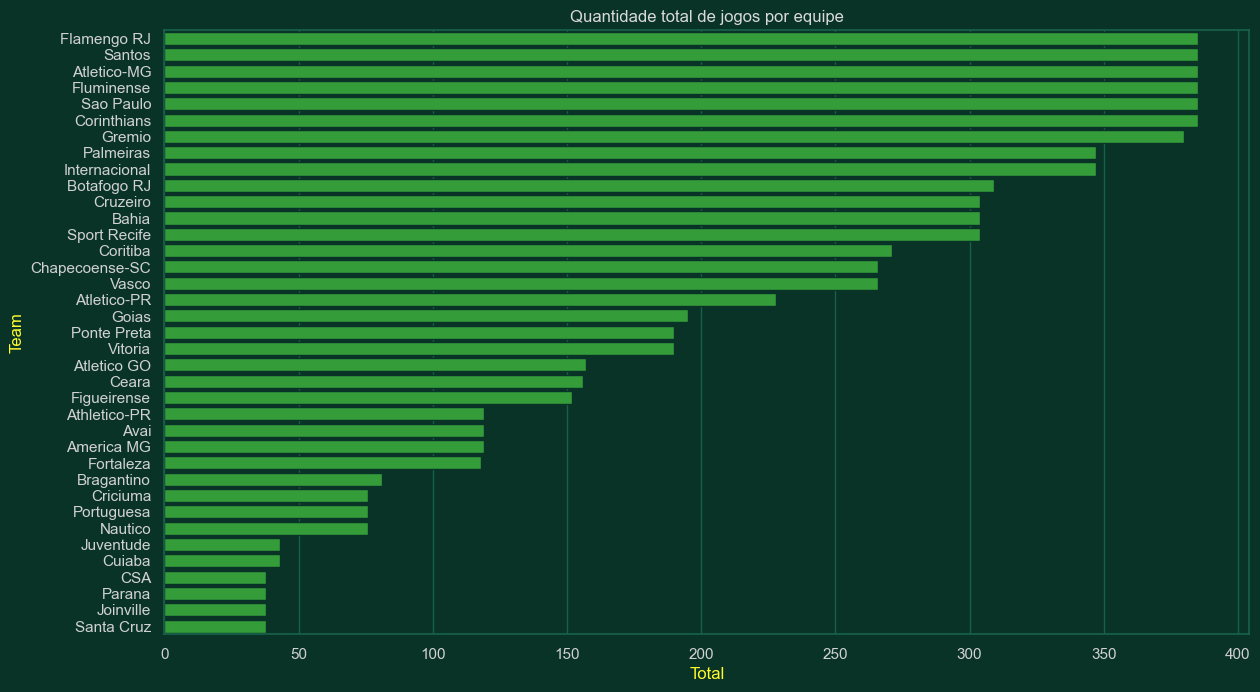

In [23]:
ax = sns.barplot(y=total['Team'], x=total['Total'], color=colors[1])
plt.title('Quantidade total de jogos por equipe')
plt.show()

In [24]:
data.groupby('Res')['Home', 'Away'].describe()

Home                           Away                         
    count unique          top freq count unique          top freq
Res                                                              
A     926     37  Botafogo RJ   48   926     37  Flamengo RJ   68
D    1037     37  Corinthians   62  1037     37  Atletico-MG   61
H    1885     37  Atletico-MG  126  1885     37   Fluminense   92

Aqui vemos informações importantes e relevantes que com certeza impactarão no resultado do modelo preditivo:
* Atlético-MG é o clube com mais vitórias jogando como mandante os seus jogos, enquanto que o Flamengo RJ é o clube com mais vitórias jogando como visitante.
* Corinthians é o clube com mais empates jogando como mandante, já o Atlético-MG é o clube com mais empates jogando como visitante.
* O Botafogo RJ é a equipe que mais perde jogos sendo mandante no campeonato, enquanto que o Fluminense é a equipe que mais perde jogos sendo visitante. Curiosidade que os dois clubes que mais perdem jogos são do estado do Rio de Janeiro. 

Text(0.5, 1.0, 'Maiores vencedores como mandantes')

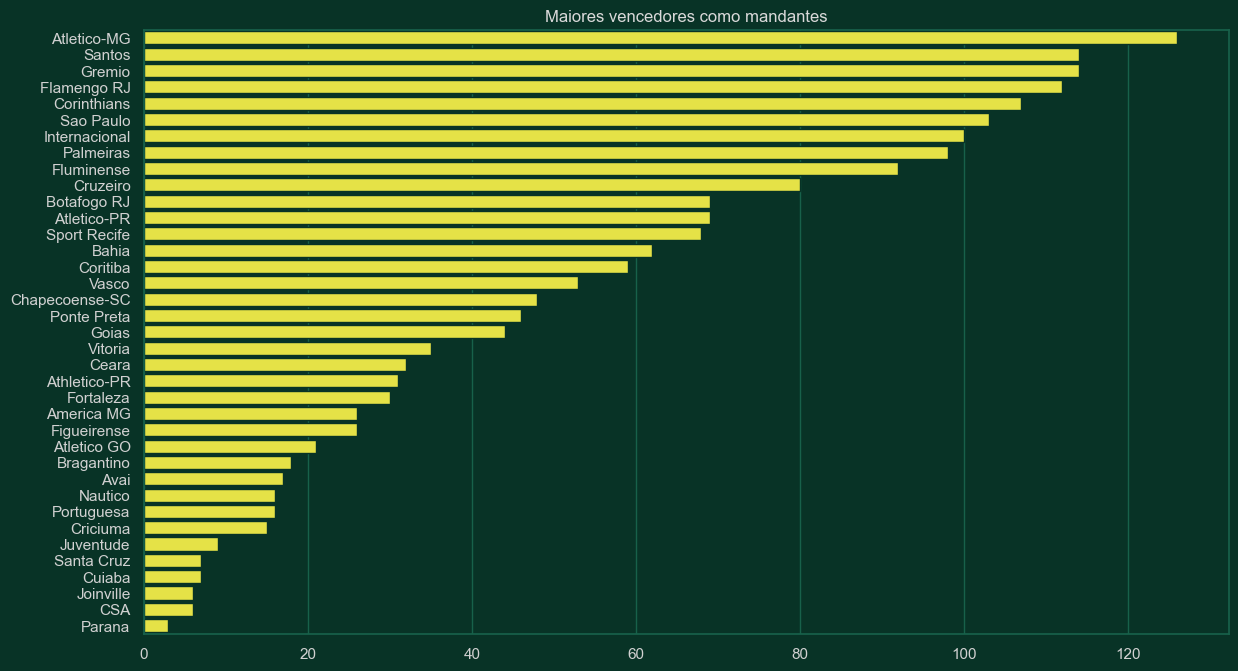

In [25]:
maiorHome = data.loc[data['Res'] == 'H', ['Home']]
sns.barplot(x=maiorHome['Home'].value_counts().values, y=maiorHome['Home'].value_counts().index, color=colors[0])
plt.title('Maiores vencedores como mandantes')

Text(0.5, 1.0, 'Maiores vencedores como visitantes')

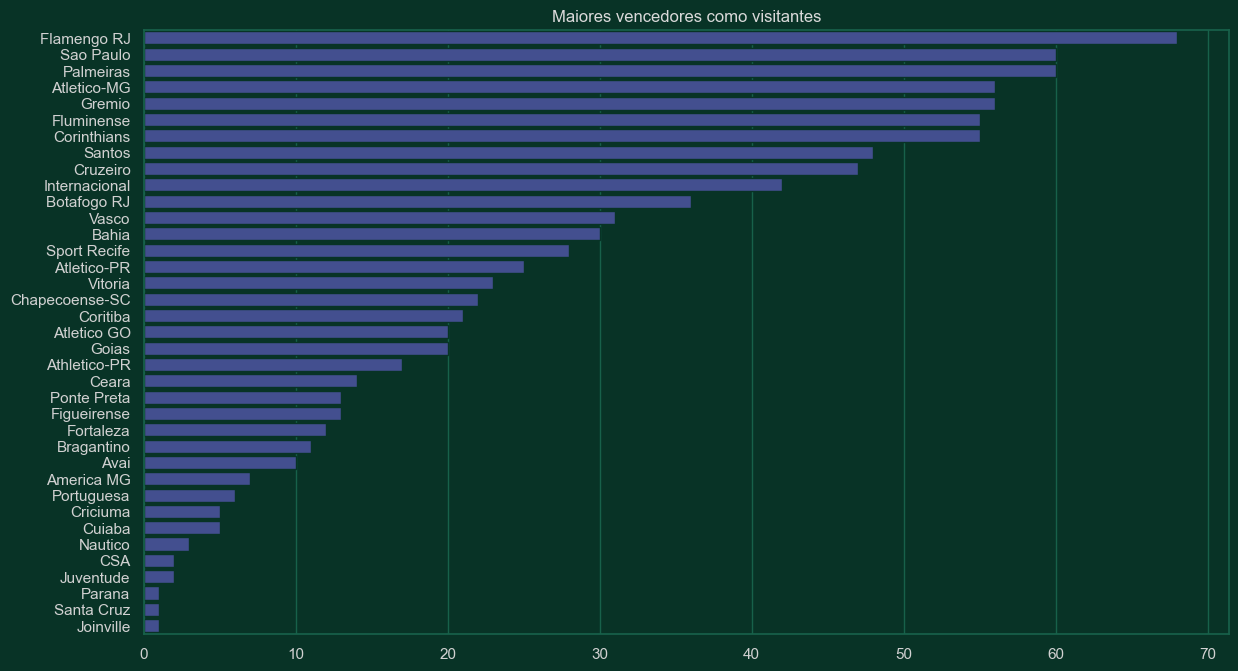

In [26]:
maiorAway = data.loc[data['Res'] == 'A', ['Away']]
sns.barplot(x=maiorAway['Away'].value_counts().values, y=maiorAway['Away'].value_counts().index, color=colors[3])
plt.title('Maiores vencedores como visitantes')

### 2) Limpeza e Pré processamento dos dados

**Dropando colunas desnecessárias**<br/>
Como dito anteriormente, alguns atributos são irrelevantes para o modelo, enquanto que outros são impossíveis de se obter antes do jogo acontecer, então iremos descartá-los.

In [27]:
colunas = ['Country', 'League', 'HG', 'AG']
data.drop(columns=colunas, inplace=True)

In [28]:
data.head()

,Season,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,2012,19/05/2012,22:30,Palmeiras,Portuguesa,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,2012,20/05/2012,01:00,Figueirense,Nautico,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,2012,20/05/2012,20:00,Corinthians,Fluminense,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


**Tratando valores missing**

In [29]:
data.isnull().sum()

Season    0
Date      0
Time      0
Home      0
Away      0
Res       1
PH        1
PD        1
PA        1
MaxH      0
MaxD      0
MaxA      0
AvgH      0
AvgD      0
AvgA      0
dtype: int64

O dataset possui apenas um registro missing. Na verdade a partida que não possui os dados foi o jogo entre Atlético-MG e Chapecoense-SC. Esta partida foi cancelada, pois foi na época que aconteceu o acidente que envolveu os jogadores do clube de Santa Catarina.
A melhor solução será dropar esse registro, já que se trata de uma partida que não aconteceu.

In [30]:
#A partida entre Chapecoense-SC e Atletico-MG foi cancelada,
#Foi o ano que houve o acidente envolvendo os jogadores do clube de SC
##Vamos dropar esse registro
data.loc[data.PH.isnull() == True]

,Season,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
1891,2016,11/12/2016,19:00,Chapecoense-SC,Atletico-MG,NaN,NaN,NaN,NaN,2.85,3.3,2.68,2.85,3.3,2.67


In [31]:
data.dropna(inplace=True)

**Mapeando os dados categóricos**<br/>
A grande maioria dos algoritmos de Machine Learning não preveem e nem aceitam dados categóricos, portanto devemos tratar esses dados de alguma forma.<br/>
Vamos mapear primeiro a variável target, transformar o valores categóricos em numéricos. Portanto a saída ficará assim:
* 1: Vitória da equipe mandante;
* 0: Empate;
* -1: Vitória da equipe visitante.

In [32]:
res_map = {'H': 1,
           'D': 0,
           'A': -1}

data['Res'] = data['Res'].map(res_map)

Criação de uma função que faz o mapeamento automático do atributo passado como parâmetro

In [33]:
#Criando um mapeamento de maneira automática
def criar_dict(df, coluna):
    temp = pd.DataFrame(df[coluna].value_counts()).sort_index()
    temp['cont'] = range(1, len(temp) + 1)
    temp = temp.drop(columns=coluna)
    dic = temp.to_dict()
    return dic['cont']

map_teams = criar_dict(data, 'Home')

Aqui eu decidi mapear os atributos Home e Away, uma vez que são atributos categóricos e devemos tratar de alguma forma.

In [34]:
data['Home_categorical'] = data['Home'].map(map_teams)
data['Away_categorical'] = data['Away'].map(map_teams)

**Vamos categorizar os atributos Time e Date seguindo a mesma lógica dos atributos Home e Away**<br/>
Tavez esses atributos da forma como foram mapeados mais atrapalhem do que ajudem, mas vamos testar várias combinações para analisar o impacto que esse tipo de mapeamento causará no modelo.

In [35]:
map_time = criar_dict(data, 'Time')
map_date = criar_dict(data, 'Date')

In [36]:
data['Time_categorical'] = data['Time'].map(map_time)
data['Date_categorical'] = data['Date'].map(map_date)

In [37]:
data.head()

,Season,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,Home_categorical,Away_categorical,Time_categorical,Date_categorical
0,2012,19/05/2012,22:30,Palmeiras,Portuguesa,0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,28,31,32,646
1,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58,35,19,32,646
2,2012,20/05/2012,01:00,Figueirense,Nautico,1,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64,18,27,9,686
3,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,1,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84,8,34,22,686
4,2012,20/05/2012,20:00,Corinthians,Fluminense,-1,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89,13,20,22,686


**One Hot Enconding**<br/>
Um ponto muito importante que deve ser levado em consideração ao transformar variáveis categóricas em variáveis numéricas é tomar cuidado para o significado dos dados não mude.<br/>
Por exemplo: Ao mapear o atributo Home, como sendo: 1-Flamengo, 2-Palmeiras, 3-Atlético-MG, 4-Corinthians, etc.. acontece de que a maioria dos algoritmos de Machine Learning vão entender estes dados como sendo sequenciais e ordenados, afetando negativamente o modelo.<br/>
Por isso decidi criar um novo dataset aplicando o one-hot-enconding nos atributos Home e Away.

In [38]:
#Função que aplica o one hot enconding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encoder(df, col):
    X = df.values
    valores_Pclass = list(df[col].sort_values().unique())
    colunas = []
    for i in valores_Pclass:
        colunas.append(col + '_' + str(i))
    colunas = colunas + list(df.columns)
    
    labelencoder_Pclass = LabelEncoder()
    X[:, 0] = labelencoder_Pclass.fit_transform(X[:, 0])
    
    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = onehotencoder.fit_transform(df[[col]]).toarray()
    enc_df = pd.DataFrame(enc_df)
    
    df = enc_df.join(df)
    df.columns = colunas
    df.drop(col, axis=1, inplace=True)
    
    return df

In [39]:
data2 = encoder(data, 'Home')
data2 = encoder(data2, 'Away')

In [40]:
data2.dropna(inplace=True)

In [41]:
data2.head()

,Away_America MG,Away_Athletico-PR,Away_Atletico GO,Away_Atletico-MG,Away_Atletico-PR,Away_Avai,Away_Bahia,Away_Botafogo RJ,Away_Bragantino,Away_CSA,...,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,Home_categorical,Away_categorical,Time_categorical,Date_categorical
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.76,3.87,5.31,1.69,3.50,4.90,28.0,31.0,32.0,646.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.83,3.42,2.70,2.59,3.23,2.58,35.0,19.0,32.0,646.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.67,4.05,7.22,1.59,3.67,5.64,18.0,27.0,9.0,686.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.49,3.39,3.15,2.35,3.26,2.84,8.0,34.0,22.0,686.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.96,3.53,4.41,1.89,3.33,3.89,13.0,20.0,22.0,686.0


In [42]:
data.head()

,Season,Date,Time,Home,Away,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,Home_categorical,Away_categorical,Time_categorical,Date_categorical
0,2012,19/05/2012,22:30,Palmeiras,Portuguesa,0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,28,31,32,646
1,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58,35,19,32,646
2,2012,20/05/2012,01:00,Figueirense,Nautico,1,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64,18,27,9,686
3,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,1,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84,8,34,22,686
4,2012,20/05/2012,20:00,Corinthians,Fluminense,-1,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89,13,20,22,686


### 3) Modelagem

Agora vamos modelar o dataset para aplicar os algoritmos de Machine Learning.<br/>
As etapas consistem em:
* Selecionar somente os atributos que serão utilizados na versão do modelo;
* Padronizar os dados;
* Dividir o conjunto de dados em treino, teste e validação;
* Aplicar os algoritmos de Machine Learning.

**Seleção de atributos**<br/>
A primeira parte da modelagem dos dados é selecionar os melhores atributos para a construção do modelo. Para isso vamos utilizar a função SelectKBest do Scikit-Learning que utiliza além da correlação das variáveis, mais algumas métricas para nos dizer quais atributos são os mais relevantes para o modelo.

In [91]:
from sklearn.feature_selection import SelectKBest

In [92]:
colunas_drop = ['Date', 'Time', 'Home', 'Away', 'Res']
features_list = ['Season', 'PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD',
       'AvgA', 'Home_categorical', 'Away_categorical', 'Time_categorical',
       'Date_categorical']
features = data.drop(colunas_drop, axis=1) #A função SelectKBest  funciona somente com atributos numéricos, por isso dropamos os atributos categóricos
target = data['Res']

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, target)
k_best_scores = k_best_features.scores_
raw_pairs = zip(features_list, k_best_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

dicionario = {
    'Atributo': list(k_best_features_final.keys()),
    'Valor': list(k_best_features_final.values()) 
}

pd.DataFrame(dicionario)

,Atributo,Valor
0,PH,154.497585
1,AvgH,149.681919
2,AvgA,143.278938
3,PA,136.859756
4,MaxA,135.307882
5,MaxH,135.254897
6,MaxD,67.108791
7,AvgD,65.887455
8,PD,64.678581
9,Season,1.393195


Aqui podemos perceber que aqueles atributos que nós mapeamos não são relevantes para o modelo, por outro lado, os atributos que referem-se as estatísticas e probabilidades são muito importantes para o modelo.

In [93]:
target = data['Res']
colunas_drop1  = ['Res', 
                 'Date', 'Time',
                 'Away_categorical',
                 'Home_categorical',
                 'Date_categorical',
                 'Time_categorical',
                 'Season'
                 ]

colunas_drop2  = ['Res', 
                 'Date', 'Time',
                 'Away_categorical',
                 'Home_categorical',
                 'Date_categorical',
                 'Time_categorical',
                 'Season',
                 'PD',
                 'AvgD',
                 'MaxD'
                 ]


dataV1 = data.drop(columns=colunas_drop1)
dataV2 = data.drop(columns=colunas_drop2)
dataV3 = data2.drop(columns=colunas_drop1)
dataV4 = data2.drop(columns=colunas_drop2)

dataV1.drop(columns=['Home', 'Away'], inplace=True)
dataV2.drop(columns=['Home', 'Away'], inplace=True)

**Agora temos 4 datasets**
Tínhamos dividido nosso dataset em dois: O primeiro que possuia apenas a conversão das variáveis categóricas para numéricas e o segundo possuia além dessa conversão, a aplicação do método de one-hot-enconding.<br/>
Ao aplicar o SelectKBest e ele nos dizer quais são os melhores atributos para o modelo, eu decidi pegar dois grupos:
* O primeiro com somente os atributos com a pontuação acima de 100;
* O segundo com a pontuação acima de 50;

Aplicando essa divisão de grupos nos dois datasets, temos agora 4 datasets que serão utilizados para os testes.

In [94]:
dataV1.head()

,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [95]:
dataV2.head()

,PH,PA,MaxH,MaxA,AvgH,AvgA
0,1.75,5.25,1.76,5.31,1.69,4.90
1,2.83,2.68,2.83,2.70,2.59,2.58
2,1.60,6.72,1.67,7.22,1.59,5.64
3,2.49,3.15,2.49,3.15,2.35,2.84
4,1.96,4.41,1.96,4.41,1.89,3.89


In [96]:
dataV3.head()

,Away_America MG,Away_Athletico-PR,Away_Atletico GO,Away_Atletico-MG,Away_Atletico-PR,Away_Avai,Away_Bahia,Away_Botafogo RJ,Away_Bragantino,Away_CSA,...,Home_Vitoria,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [97]:
dataV4.head()

,Away_America MG,Away_Athletico-PR,Away_Atletico GO,Away_Atletico-MG,Away_Atletico-PR,Away_Avai,Away_Bahia,Away_Botafogo RJ,Away_Bragantino,Away_CSA,...,Home_Sao Paulo,Home_Sport Recife,Home_Vasco,Home_Vitoria,PH,PA,MaxH,MaxA,AvgH,AvgA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.75,5.25,1.76,5.31,1.69,4.90
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.83,2.68,2.83,2.70,2.59,2.58
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.60,6.72,1.67,7.22,1.59,5.64
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.49,3.15,2.49,3.15,2.35,2.84
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.96,4.41,1.96,4.41,1.89,3.89


**Padronização dos dados**<br/>
Após selecionar so atributos que serão utilizados vamos padronizar os dados. A etapa de padronização tem alguns propósitos:
* Deixar todos os atributos na mesma escala, evitando que os dados fiquem muito dispersos;
* Normalmente as padronizações transformam os dados em um mapa de valores entre -1 e 1 (Dependendo da técnica), com isso o processamento computacional se torna menos custoso, pois a máquina não precisa realizar cálculos com valores exorbitantes;
* A principal função da padronização é aproximar os dados de uma distribuição normal, dado que vários algoritmos de Machine Learning se saem melhor com dados normalmente distribuídos.

Vamos utilizar duas técnicas, a StandardScaler, para uma padronização mais padrão, assim como o nome sugere e a Normalizer, que é uma técnica para normalizar os dados e deixá-los normalmente distribuídos.


In [98]:
#from sklearn.preprocessing import QuantileTransformer
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [99]:
X_standard1 = dataV1.copy()
X_standard1 = StandardScaler().fit_transform(dataV1)

X_standard2 = dataV2.copy()
X_standard2 = StandardScaler().fit_transform(dataV2)

X_standard3 = dataV3.copy()
X_standard3 = StandardScaler().fit_transform(dataV3)

X_standard4 = dataV4.copy()
X_standard4 = StandardScaler().fit_transform(dataV4)

In [100]:
X_normalizer1 = dataV1.copy()
X_normalizer1 = Normalizer().fit_transform(dataV1)

X_normalizer2 = dataV2.copy()
X_normalizer2 = Normalizer().fit_transform(dataV2)

X_normalizer3 = dataV3.copy()
X_normalizer3 = Normalizer().fit_transform(dataV3)

X_normalizer4 = dataV4.copy()
X_normalizer4 = Normalizer().fit_transform(dataV4)

Aplicando as duas técnicas para cada um dos nossos datasets, temos agora oito datasets.

In [101]:
list_X = {
    'X_standard1': X_standard1,
    'X_standard2': X_standard2,
    'X_standard3': X_standard3,
    'X_standard4': X_standard4,
    'X_normalizer1': X_normalizer1,
    'X_normalizer2': X_normalizer2,
    'X_normalizer3': X_normalizer3,
    'X_normalizer4': X_normalizer4
}

Y = target

**Divisão treino e teste**

Esta é a etapa onde dividimos nossos dados em um conjunto de Treino, outro para Testes, e ainda um terceiro conjunto para Validações. Poderíamos utilizar o train_test_split que é uma excelente função para realizar uma divisão nos conjuntos de dados. Porém, vamos realizar o treinamento com os dados sequenciais até a temporada de 2020, e separar a temporada de 2021 para ralizarmos as previsões.

In [54]:
#from sklearn.model_selection import GridSearchCV, train_test_split
#x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size = 0.33, random_state = 101)

In [55]:
#Fazendo uma divisão de treino e teste por temporada
print(data['Season'].iloc[3415:3420]) #Onde exatamente começa a temporada 2021
print(data['Season'].iloc[3795:3800]) #Onde exatamente começa a temporada 2022

3416    2020
3417    2020
3418    2020
3419    2020
3420    2021
Name: Season, dtype: int64
3796    2021
3797    2021
3798    2021
3799    2021
3800    2022
Name: Season, dtype: int64


Os nossos index para separar nosso conjunto de dados foram definidos:
* 0 - 3419: Dados da temporada 2012 até 2020.
* 3419 - 3799: Dados da temporada 2021.

In [56]:
index_ini_treino = 0
index_fim_treino = 3419
index_ini_teste = 3419
index_fim_teste = 3799

**Cross Validation (K-Fold)**
Neste caso nós também não iremos aplicar a validação cruzada, pelos motivos que eu citei no item acima. Mas fica a sugestão para estudos posteriores.

In [57]:
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
#k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### 4) Aplicação dos algoritmos de Machine Learning

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from time import time

Vamos criar uma lista para guardar as informações detelhadas do nosso treinamento.

In [59]:
lst_detalhes = []

#obj = {
#    'Algoritmo': O algoritmo que será utilizado, 
#    'Dataset': Qual dentre os nossos 8 datasets,
#    'Acurácia' A precisão do modelo: 
#}

##### **Criando método GridSearch**

O GridSearch é o principal método para testar diferentes combinações de parâmetros dos modelos, parâmetros estes que demandariam muito tempo se fossem testados manualmente.<br/>
Por isso decidi criar um método de GridSearch que recebe o modelo, um dicionário com os parâmetros do modelo, os dados de treino e teste e um parâmetro que serve como label para indicar qual é o modelo/conjunto de dados que está sendo testado.

In [60]:
def modeloGrid(modelo, parametros, x_train, y_train, x_test, y_test, nome_modelo, nome_dataset):
    modeloGrid = GridSearchCV(modelo, parametros, cv = 10)
    
    modeloGrid.fit(x_train, y_train)
    
    acuracia = round(accuracy_score(y_test, modeloGrid.predict(x_test)) * 100, 2)
    print('Melhor performance do modelo {} {}: {:.2f}%'.format(nome_modelo, nome_dataset, acuracia))

    obj = {
        'Algoritmo': nome_modelo, 
        'Dataset': nome_dataset,
        'Acurácia' : acuracia
    }
    lst_detalhes.append(obj)
    
    return modeloGrid

##### **KNN**

O KNN é um dos algoritmos mais simples para Machine Learning, sendo um algoritmo do tipo "lazy", ou seja, nenhuma computação é realizada no dataset até que um novo ponto de dado seja alvo de teste.<br/>

Ele é um algoritmo não-linear que utiliza uma métrica de distância para encontrar o valor de K mais adequado as instâncias do dataset de treino.

In [61]:
#Criando o modelo KNN
KNN = KNeighborsClassifier()

# Definição de parâmetros
k = np.arange(20) + 1
parametros = {'n_neighbors':k}

In [62]:
for item in list_X.items():
    X = item[1]

    x_train = X[index_ini_treino :index_fim_treino]
    y_train = Y[index_ini_treino :index_fim_treino]
    x_test = X[index_ini_teste :index_fim_teste]
    y_test = Y[index_ini_teste :index_fim_teste]
    modelo = modeloGrid(KNN, parametros, x_train, y_train, x_test, y_test, 'KNN', item[0])

Melhor performance do modelo KNN X_standard1: 47.89%
Melhor performance do modelo KNN X_standard2: 47.63%
Melhor performance do modelo KNN X_standard3: 45.26%
Melhor performance do modelo KNN X_standard4: 45.79%
Melhor performance do modelo KNN X_normalizer1: 45.79%
Melhor performance do modelo KNN X_normalizer2: 47.63%
Melhor performance do modelo KNN X_normalizer3: 44.21%
Melhor performance do modelo KNN X_normalizer4: 45.53%


In [63]:
pd.DataFrame(lst_detalhes)

,Algoritmo,Dataset,Acurácia
0,KNN,X_standard1,47.89
1,KNN,X_standard2,47.63
2,KNN,X_standard3,45.26
3,KNN,X_standard4,45.79
4,KNN,X_normalizer1,45.79
5,KNN,X_normalizer2,47.63
6,KNN,X_normalizer3,44.21
7,KNN,X_normalizer4,45.53


##### **Decision Tree**

É um tipo de algoritmo que cria uma estrutura de árvore até que uma decisão seja feita para um determinado registro. Inicia sempre de um nó raiz, a partir daí selecionando os outros atributos e tomando decisões.

In [64]:
#Criando o modelo de Árvore de Decisão
Decision_Tree = DecisionTreeClassifier()

parametros = {
    'max_depth' : ([1, 2, 3, 4, 5, 6]),
    'max_features': ([None, 'sqrt', 'log2']),
    'criterion': (['entropy', 'gini']),
    'min_samples_leaf': ([1, 2, 3]), 
    'min_samples_split': ([2, 4, 8, 10])

}

In [65]:
for item in list_X.items():
    X = item[1]
    nome = 'Decision Tree ' + item[0]

    x_train = X[0:3419]
    y_train = Y[0:3419]
    x_test = X[3419:3799]
    y_test = Y[3419:3799]
    modelo = modeloGrid(Decision_Tree, parametros, x_train, y_train, x_test, y_test, 'Decision Tree', item[0])

Melhor performance do modelo Decision Tree X_standard1: 47.11%
Melhor performance do modelo Decision Tree X_standard2: 51.58%
Melhor performance do modelo Decision Tree X_standard3: 49.47%
Melhor performance do modelo Decision Tree X_standard4: 50.79%
Melhor performance do modelo Decision Tree X_normalizer1: 50.79%
Melhor performance do modelo Decision Tree X_normalizer2: 51.32%
Melhor performance do modelo Decision Tree X_normalizer3: 48.16%
Melhor performance do modelo Decision Tree X_normalizer4: 42.63%


In [66]:
pd.DataFrame(lst_detalhes).sort_values(by='Acurácia', ascending=False)

,Algoritmo,Dataset,Acurácia
9,Decision Tree,X_standard2,51.58
13,Decision Tree,X_normalizer2,51.32
11,Decision Tree,X_standard4,50.79
12,Decision Tree,X_normalizer1,50.79
10,Decision Tree,X_standard3,49.47
14,Decision Tree,X_normalizer3,48.16
0,KNN,X_standard1,47.89
1,KNN,X_standard2,47.63
5,KNN,X_normalizer2,47.63
8,Decision Tree,X_standard1,47.11


##### **Random Forest**

Modelos compostos por múltiplos modelos mais fracos que são independentemente treinados e a previsão combina esse modelos de alguma forma; Criam vários modelos de árvores diferentes, selecionando diferentes atributos com diferentes configurações. A partir daí o melhor modelo será selecionado através de um processo de votação.

In [67]:
RandomForest = RandomForestClassifier()

parametros = {'n_estimators': [5],
              'max_depth': [10, 25, 50],
              'bootstrap': ([True, False]),
              'criterion': (['entropy', 'gini']),
              'min_samples_leaf': ([1, 2, 4, 6]),
              'min_samples_split': ([2, 10, 22])
             }

In [68]:
for item in list_X.items():
    X = item[1]

    x_train = X[0:3419]
    y_train = Y[0:3419]
    x_test = X[3419:3799]
    y_test = Y[3419:3799]
    modelo = modeloGrid(RandomForest, parametros, x_train, y_train, x_test, y_test, 'Random Forest', item[0])

Melhor performance do modelo Random Forest X_standard1: 47.37%
Melhor performance do modelo Random Forest X_standard2: 48.68%
Melhor performance do modelo Random Forest X_standard3: 46.84%
Melhor performance do modelo Random Forest X_standard4: 48.95%
Melhor performance do modelo Random Forest X_normalizer1: 51.05%
Melhor performance do modelo Random Forest X_normalizer2: 50.26%
Melhor performance do modelo Random Forest X_normalizer3: 49.74%
Melhor performance do modelo Random Forest X_normalizer4: 46.05%


In [69]:
pd.DataFrame(lst_detalhes).sort_values(by='Acurácia', ascending=False)

,Algoritmo,Dataset,Acurácia
9,Decision Tree,X_standard2,51.58
13,Decision Tree,X_normalizer2,51.32
20,Random Forest,X_normalizer1,51.05
12,Decision Tree,X_normalizer1,50.79
11,Decision Tree,X_standard4,50.79
21,Random Forest,X_normalizer2,50.26
22,Random Forest,X_normalizer3,49.74
10,Decision Tree,X_standard3,49.47
19,Random Forest,X_standard4,48.95
17,Random Forest,X_standard2,48.68


##### **Naive Bayes**

O Naive Bayes é um tipo de classificador que desconsidera a correlação entre os atributos, cada atributo é tratado individualmente.

A resolução de problemas relacionados a texto é muito bem resolvida com a utilização do Naive Bayes. Classificação de textos, filtragem de SPAM e análise de sentimento em redes sociais são algumas das muitas aplicações para o algoritmo.

In [70]:
from sklearn.naive_bayes import GaussianNB

In [71]:
#Treinando

for item in list_X.items():
    NaiveBayes = GaussianNB()
    X = item[1]

    x_train = X[0:3419]
    y_train = Y[0:3419]
    x_test = X[3419:3799]
    y_test = Y[3419:3799]
    NaiveBayes.fit(x_train, y_train)
    
    acuracia = round(accuracy_score(y_test, NaiveBayes.predict(x_test)) * 100, 2)
    print('Melhor performance do modelo Naive Bayes: {:.2f}%'.format(acuracia))

    obj = {
        'Algoritmo': 'Naive Bayes', 
        'Dataset': item[0],
        'Acurácia' : acuracia
    }
    lst_detalhes.append(obj)


Melhor performance do modelo Naive Bayes: 42.11%
Melhor performance do modelo Naive Bayes: 47.63%
Melhor performance do modelo Naive Bayes: 32.89%
Melhor performance do modelo Naive Bayes: 31.84%
Melhor performance do modelo Naive Bayes: 46.84%
Melhor performance do modelo Naive Bayes: 47.37%
Melhor performance do modelo Naive Bayes: 35.00%
Melhor performance do modelo Naive Bayes: 32.37%


In [72]:
pd.DataFrame(lst_detalhes).sort_values(by='Acurácia', ascending=False)

,Algoritmo,Dataset,Acurácia
9,Decision Tree,X_standard2,51.58
13,Decision Tree,X_normalizer2,51.32
20,Random Forest,X_normalizer1,51.05
11,Decision Tree,X_standard4,50.79
12,Decision Tree,X_normalizer1,50.79
21,Random Forest,X_normalizer2,50.26
22,Random Forest,X_normalizer3,49.74
10,Decision Tree,X_standard3,49.47
19,Random Forest,X_standard4,48.95
17,Random Forest,X_standard2,48.68


##### **Logistic Regression**

A regressão logística é um algoritmo de aprendizagem de máquina supervisionado utilizado para classificação, apesar de ter a palavra regressão em seu nome.<br/>
Esta consiste em analisar cada classe de forma separada contra todas as outras, criando um classificador para cada possibilidade, dessa forma se calcula a probabilidade de uma dada instância pertencer a classe em questão ou não. Ao final, a classe selecionada será aquela que apresentar a maior probabilidade.

In [116]:
logistRegression = LogisticRegression()

parametros = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'intercept_scaling': [0, 0.5, 1],
    'multi_class': ['multinomial']
}

for item in list_X.items():
    X = item[1]

    x_train = X[0:3419]
    y_train = Y[0:3419]
    x_test = X[3419:3799]
    y_test = Y[3419:3799]
    modelo = modeloGrid(logistRegression, parametros, x_train, y_train, x_test, y_test, 'Logistic Regression', item[0])

Melhor performance do modelo Logistic Regression X_standard1: 52.11%
Melhor performance do modelo Logistic Regression X_standard2: 51.05%
Melhor performance do modelo Logistic Regression X_standard3: 47.63%
Melhor performance do modelo Logistic Regression X_standard4: 49.21%
Melhor performance do modelo Logistic Regression X_normalizer1: 51.05%
Melhor performance do modelo Logistic Regression X_normalizer2: 51.32%
Melhor performance do modelo Logistic Regression X_normalizer3: 50.26%
Melhor performance do modelo Logistic Regression X_normalizer4: 50.26%


In [117]:
pd.DataFrame(lst_detalhes).sort_values(by='Acurácia', ascending=False).head(10)

,Algoritmo,Dataset,Acurácia
50,Logistic Regression,X_standard1,52.11
9,Decision Tree,X_standard2,51.58
55,Logistic Regression,X_normalizer2,51.32
13,Decision Tree,X_normalizer2,51.32
20,Random Forest,X_normalizer1,51.05
54,Logistic Regression,X_normalizer1,51.05
36,SVM,X_normalizer1,51.05
51,Logistic Regression,X_standard2,51.05
37,SVM,X_normalizer2,51.05
44,SVM,X_normalizer3,51.05


##### **SVM**

O algoritmo Support Vector Machine traça uma reta e tenta separar linearmente e classificar o conjunto de dados. O algoritmo tenta encontrar a reta que tenha maior distância dentre as classes prevista.<br/>

Para aplicar o SVC em conjuntos de dados não linearmente separáveis é necessário configurar o parâmetro Kernel. Este parâmetro é responsável por traçar não somente retas, mas também outros tipos de linhas no conjunto de dados.<br/>

> Possibilidades: kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

In [74]:
SVM = SVC()

# Template para utilizar o GridSearch e experimentar diferentes parâmetros
# Porém a execução vai ser bem mais demorada
#parametros = {'kernel': ['linear', 'rbf', 'sigmoid'], 
#              'C': [1, 2, 4],
#              'gamma': [0.25, 0.75, 1]}

parametros = {}

for item in list_X.items():
    X = item[1]

    x_train = X[0:3419]
    y_train = Y[0:3419]
    x_test = X[3419:3799]
    y_test = Y[3419:3799]
    modelo = modeloGrid(SVM, parametros, x_train, y_train, x_test, y_test, 'SVM', item[0])
    


Melhor performance do modelo SVM X_standard1: 50.79%
Melhor performance do modelo SVM X_standard2: 51.05%
Melhor performance do modelo SVM X_standard3: 48.95%
Melhor performance do modelo SVM X_standard4: 48.42%
Melhor performance do modelo SVM X_normalizer1: 50.53%
Melhor performance do modelo SVM X_normalizer2: 50.79%
Melhor performance do modelo SVM X_normalizer3: 51.05%
Melhor performance do modelo SVM X_normalizer4: 51.05%


In [118]:
pd.DataFrame(lst_detalhes).sort_values(by='Acurácia', ascending=False).head(15)

,Algoritmo,Dataset,Acurácia
50,Logistic Regression,X_standard1,52.11
9,Decision Tree,X_standard2,51.58
55,Logistic Regression,X_normalizer2,51.32
13,Decision Tree,X_normalizer2,51.32
20,Random Forest,X_normalizer1,51.05
54,Logistic Regression,X_normalizer1,51.05
36,SVM,X_normalizer1,51.05
51,Logistic Regression,X_standard2,51.05
37,SVM,X_normalizer2,51.05
44,SVM,X_normalizer3,51.05


**Considerações sobre os modelos criados**<br/><br/>
Dentre todos os modelos criados, o que obteve o melhor desempenho seguindo as métricas de acurácia foram Logistic Regression, Decision Tree e SVM. <br/><br/>
Porém, um ponto que devemos levar em consideração sobre as árvores de decisões é que o fato delas obterem uma melhor acurácia nesses testes não significam que serão sempre assim. O modelo Random Forest é um conjunto de árvores e por se tratar de um método que testa várias árvores de decisão se torna muito mais confiável com os resultados mais próximos da realidade.<br/><br/>
Já as SVMs são uma familia de algoritmos muito complexas, e seu tempo de treinamento foi bastante demorado.
Por outro lado, a regressão logística se saiu bastante performática em relação aos outros algoritmos. Tanto em precisão da acurácia, quanto em velocidade de execução.

In [124]:
logistRegression = LogisticRegression()

parametros = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'intercept_scaling': [0, 0.25, 0.4, 0.5, 0.75, 1],
    'multi_class': ['multinomial'],
    'C': [0, 0.25, 0.4, 0.5, 0.75, 1]
}

_X = list_X['X_standard1']

x_train = _X[0:3419]
y_train = Y[0:3419]
x_test = _X[3419:3799]
y_test = Y[3419:3799]
modelo = modeloGrid(logistRegression, parametros, x_train, y_train, x_test, y_test, 'Logistic Regression', 'X_standard1')


Melhor performance do modelo Logistic Regression X_standard1: 52.11%


### 5) Utilizando o modelo para prever os resultados do campeonato

Abaixo estão listados os índices do início de algumas temporadas, sendo a nossa temporada alvo a de 2021, cujo os dados não foram apresentados para o modelo.
* Season 2013: 380-760
* Season 2020: 3040-3419
* Season 2021: 3420-3799 (principal alvo)

Em seguida temos o método preverTabelaCampeonato. Este método recebe como parâmetros o índice inicial e o índice final, o dataframe com os labels, o array com os valores e o modelo, e tem como saída a tabela do campeonato dentro desse intervalo específico. A tabela contém as seguintes informações:
* Equipe;
* Pontuação;
* Quantidade de vitórias;
* Quantidade de empates;
* Quantidade de derrotas;


In [121]:
def preverTabelaCampeonato(i_inicial, i_final, data, X, modelo):
    x_valid = X[i_inicial:i_final] #Intervalo no array de valores
    
    previsoes = modelo.predict(x_valid) #Realizando a previsão

    #Criação de um dataframe temporário contendo a informação do jogo
    df = pd.DataFrame({
        'Id': data.index[i_inicial:i_final], #Id do jogo
        'Home': data['Home'].iloc[i_inicial:i_final], #Clube mandante
        'Away': data['Away'].iloc[i_inicial:i_final], #Clube visitante
        'Resultado': previsoes #Resultado previsto
    })


    #Criação de mais um dataframe temporário contendo os resultados da equipe como sendo mandante dos jogos
    home = df.groupby('Home').agg({'Resultado':lambda x: [3 if x == 1 else 1 if x == 0 else 0 for x in list(x)]})
    home['PontosHome'] = [sum(a) for a in list(home['Resultado'])]
    home['VitoriasHome'] = [sum([1 if x == 3 else 0 for x in a]) for a in list(home['Resultado'])]
    home['EmpatesHome'] = [sum([1 if x == 1 else 0 for x in a]) for a in list(home['Resultado'])]
    home['DerrotasHome'] = [sum([1 if x == 0 else 0 for x in a]) for a in list(home['Resultado'])]

    #Criação de mais um dataframe temporário contendo os resultados da equipe como sendo visitante dos jogos
    away = df.groupby('Away').agg({'Resultado':lambda x: [0 if x == 1 else 1 if x == 0 else 3 for x in list(x)]})
    away['PontosAway'] = [sum(a) for a in list(away['Resultado'])]
    away['VitoriasAway'] = [sum([1 if x == 3 else 0 for x in a]) for a in list(away['Resultado'])]
    away['EmpatesAway'] = [sum([1 if x == 1 else 0 for x in a]) for a in list(away['Resultado'])]
    away['DerrotasAway'] = [sum([1 if x == 0 else 0 for x in a]) for a in list(away['Resultado'])]

    #União dos resultados obtidos da equipe mandante e visitante
    home['PontosTotais'] = home['PontosHome'] + away['PontosAway']
    home['Vitorias'] = home['VitoriasHome'] + away['VitoriasAway']
    home['Empates'] = home['EmpatesHome'] + away['EmpatesAway']
    home['Derrotas'] = home['DerrotasHome'] + away['DerrotasAway']

    #Ajustes no dataframe com os resultados finais e ordenação por pontuação, seguido de vitórias e por fim empates.
    home.reset_index(inplace=True)
    home.sort_values(by=['PontosTotais', 'Vitorias', 'Empates'], ascending=False, inplace=True)
    home.set_index(np.arange(1, home.shape[0] + 1), inplace=True)

    #Obtenção do dataframe contendo os resultados finais, seleção dos campos pertinentes
    df_final = home[['Home', 'PontosTotais', 'Vitorias', 'Empates', 'Derrotas']]
    df_final.rename(columns={"Home": "Equipe", "Vitorias": "Vitórias"}, inplace=True)

    return df_final
    

In [125]:
df_2013 = preverTabelaCampeonato(380, 760, data, _X, modelo)
df_2020 = preverTabelaCampeonato(3040, 3419, data, _X, modelo)
df_2021 = preverTabelaCampeonato(3419, 3799, data, _X, modelo)

In [129]:
df_2013

,Equipe,PontosTotais,Vitórias,Empates,Derrotas
1,Cruzeiro,84,28,0,10
2,Corinthians,78,26,0,12
3,Fluminense,72,24,0,14
4,Atletico-MG,69,23,0,15
5,Botafogo RJ,69,23,0,15
6,Internacional,69,23,0,15
7,Sao Paulo,69,23,0,15
8,Gremio,66,22,0,16
9,Flamengo RJ,63,21,0,17
10,Coritiba,57,19,0,19


In [130]:
df_2020

,Equipe,PontosTotais,Vitórias,Empates,Derrotas
1,Flamengo RJ,105,35,0,3
2,Atletico-MG,96,32,0,6
3,Palmeiras,96,32,0,6
4,Sao Paulo,90,30,0,8
5,Internacional,87,29,0,9
6,Gremio,84,28,0,10
7,Bragantino,63,21,0,17
8,Ceara,58,19,1,18
9,Athletico-PR,51,17,0,20
10,Bahia,48,16,0,22


In [131]:
df_2021

,Equipe,PontosTotais,Vitórias,Empates,Derrotas
1,Flamengo RJ,102,34,0,4
2,Atletico-MG,96,32,0,6
3,Palmeiras,78,26,0,12
4,Sao Paulo,74,24,2,12
5,Gremio,73,24,1,13
6,Internacional,66,22,0,16
7,Bragantino,61,20,1,17
8,Fortaleza,61,20,1,17
9,Corinthians,57,18,3,17
10,America MG,52,17,1,20


In [132]:
df_2021.to_excel('previsao2021.xlsx', index=True)

### 6) Considerações finais

O modelo final obteve uma acurácia de 52.11%. O resultado pode ser considerado razoável, dado a dificuldade que é realizar esse tipo de previsão. Pontos positivos e negativos do modelo:
<br/>
Como positivo podemos considerar:
* O modelo consegue dizer de maneira geral quais são os 'níveis' das equipes. Por exemplo: Ele consegue dizer que Flamego RJ, Atlético MG e Palmeiras são as melhores equipes, tanto em 2020 quanto em 2021. E quando olhamos para o passado, em 2013 o Cruzeiro e Corinthians estavam entre os melhores. O que se confirma se olharmos a tabela daquele ano.
* Além disso podemos notar que o modelo consegue dizer com precisão quaise são os clubes que lutam para não cair. Exemplo de 2020 e 2021, onde o modelo acertou 5 dos 8 clubes que foram rebaixados nestes dois anos, e quase acertou mais dois. Botafogo RJ em 2020 e Juventude em 2021.
* O modelo foi bom em dizer quais foram as equipes que figuraram entre os 10 melhores do Brasil, acertando em 7 dos 10 casos.
<br/><br/>

Como avaliação negativa do modelo podemos considerar:
* O modelo não foi bom em dizer exatamente qual a posição que a equipe terminou o campeonato.
* O modelo também previu poucos empates, o que foi bastante negativo, dado que as equipes de meio de tabela empatam bastante seus jogos.


#### 6.1) Sugestões para estudos futuros

Como estudos futuros e sugestões para quem quer melhorar o modelo a fim de obter uma melhora acurácia e aprimorar os conhecimentos sobre cada etapa e sobre Machine Learning de maneira geral cito:
* PRÉ PROCESSAMENTO: Realizar um pré processamento diferente do que foi feito, por exemplo: Mapear os dados de maneira diferente, ou ainda padronizar os dados seguindo outro algoritmo diferente dos que foram apresentados.
* SELEÇÃO DE ATRIBUTOS: Será que a data específica considerando o dia e o mês faz diferença? E o horário que o jogo aconteceu? Será que algum clube se sai melhor jogando na quarta-feira ou no domingo (dias mais comuns para partidas do campeonato brasileiro)? Talvez aplicar uma técnica diferente do SelectKBest para selecionar os melhores atributos possa indiciar atributos melhores.
* ALGORITMOS UTILIZADOS: Foram utilizados os principais algoritmos, mas ainda poderíamos utilizar outros algoritmos, além de alguns métodos focados na otimização dos algoritmos, tais como: Inserir mais parâmetros para testagem em cada algoritmo, utilizar o ExtraTreeClassifier, utilizar a otimização dos parâmetros com o AdaBoost ou o GradientBoosting.
* DEEP LEARNING!?: Será que aplicar esses dados em uma rede neural profunda com o Tensorflow pode prever um resultado melhor?
